In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [17]:
sns.set(rc={"figure.figsize":(20, 8)})

In [285]:
df = pd.read_csv("shots_2022.csv")
df = df[(df['shotOnEmptyNet']==0)&(df['shotWasOnGoal']>=0)&(df['isPlayoffGame']==0)]
df['teamScoredOn'] = df.apply(lambda x: x['awayTeamCode'] if x['awayTeamGoals']>0 else x['homeTeamCode'], axis=1)
df = df.loc[:, ["shotID", "teamScoredOn", "xCord", "yCord", "goal", "teamCode", "game_id", "goalieNameForShot", "shooterName", "shotAngle", "shotDistance", "shotType", "time"]]

#Map shot quality from 1 to 6 based on distance & if taken from behind the net
    #Rank = 1 if taken outside of offensive zone from distance greater than farthest in-zone point
    #Rank = 2 if taken from anywhere behind goal line or distance >= farthest in-zone point - 15ft (i.e. between Rank 2 and zone)
    #Rank = 3 if shot was taken outside slot or from behind the net
    #Rank = 4 if shot was taken from >= 27 feet away from net
    #Rank = 5 if shot was taken  >=21 feet away from net
    #Rank = 6 if shot was taken >= 9.5 feet away
    #Rank = 7 if shot was taken >= 7 feet away
    #Rank = 8 if shot was taken from >= 6 feet away
    #Rank = 9 if shot was taken from < 6 feet away
df['quality'] = df.apply(lambda x: 
    1 if (((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2)))&(x['yCord']<=36)&(x['yCord']>=-36)) else (
    2 if ((x['shotDistance'])>=(math.sqrt(64**2 + 42.5**2))-15) else(
    3 if (x['yCord']>=24)|(x['yCord']<=-24)|(x['xCord']<-89)|(x['xCord']>89) else(
    4 if (x['shotDistance']>= 27) else (
    5 if (x['shotDistance']>= 21) else( 
    6 if (x['shotDistance']>= 9.5) else (
    7 if (x['shotDistance']>= 7) else (
    8 if (x['shotDistance']>= 6) else 9))))))), axis=1)

df_goals=df[df['goal']>0]
def create_circle(coords, c):
    return plt.Circle(xy=(coords[0],coords[1]), radius=15, color=c, fill=False)
def plot_rink(df, title):
    rink = sns.scatterplot(x='xCord', y='yCord', data=df, hue='quality', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    plt.title(title)
    #Create rink lines
    rink.axvline(0, color='red')
    rink.axvline(-25, color='blue')
    rink.axvline(25, color='blue')
    rink.axvline(89, color='red')
    rink.axvline(-89, color='red')
    rink.add_patch(createCircle([0,0], 'blue'))
    rink.add_patch(createCircle([69,22], 'red'))
    rink.add_patch(createCircle([-69,22], 'red'))
    rink.add_patch(createCircle([69,-22], 'red'))
    rink.add_patch(createCircle([-69,-22], 'red'))
    rink.grid(False)

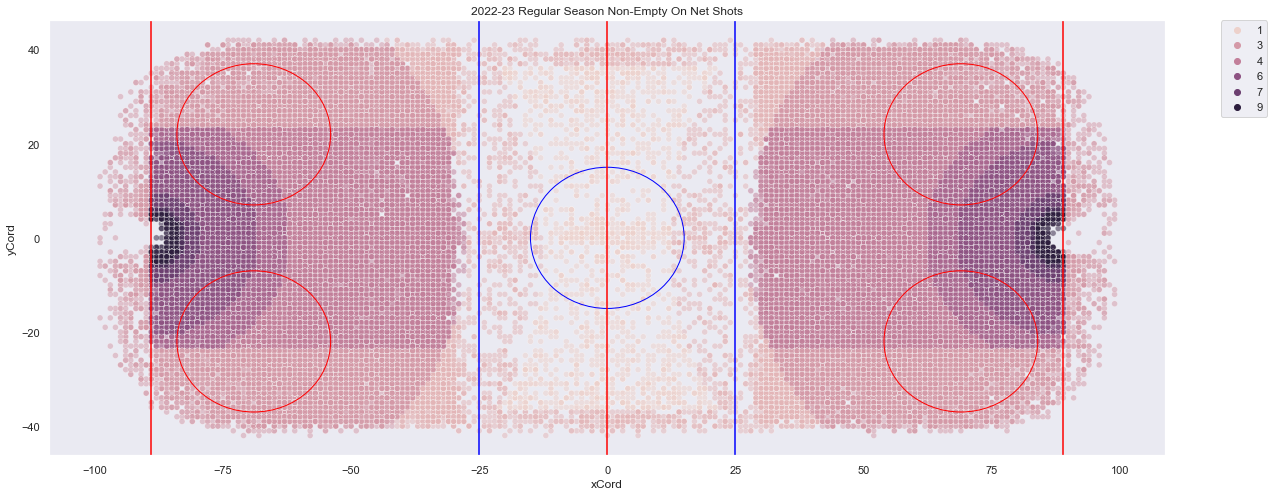

In [286]:
df_saves=df[df['goal']==0]
plot_rink(df_saves, "2022-23 Regular Season Non-Empty On Net Shots")

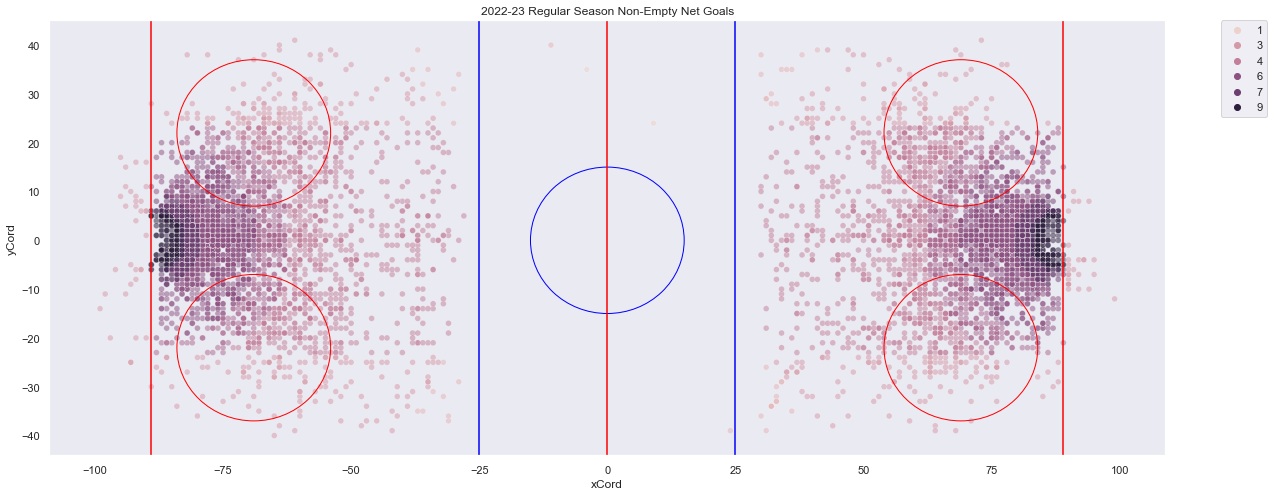

In [287]:
plot_rink(df_goals, "2022-23 Regular Season Non-Empty Net Goals")

In [288]:
#Get percentage of shots that are goals based on the quality
df2 = df
df2['goal_percentage_by_quality'] = (df2.groupby('quality')['goal'].transform('sum') / df2.groupby('quality')['goal'].transform('count')) * 100
average_goal_percentage_by_shot_quality = df2.drop_duplicates('quality').sort_values('quality')
print(df2.drop_duplicates('quality').corr()['quality']['goal_percentage_by_quality'])
print(f"1:{len(df_goals[df_goals['quality']==1])}, 2:{len(df_goals[df_goals['quality']==2])}, 3:{len(df_goals[df_goals['quality']==3])}, 4:{len(df_goals[df_goals['quality']==4])}, 5:{len(df_goals[df_goals['quality']==5])}, 6:{len(df_goals[df_goals['quality']==6])}, 7:{len(df_goals[df_goals['quality']==7])}")

0.9879008228288916
1:2, 2:44, 3:555, 4:1764, 5:997, 6:2564, 7:1239


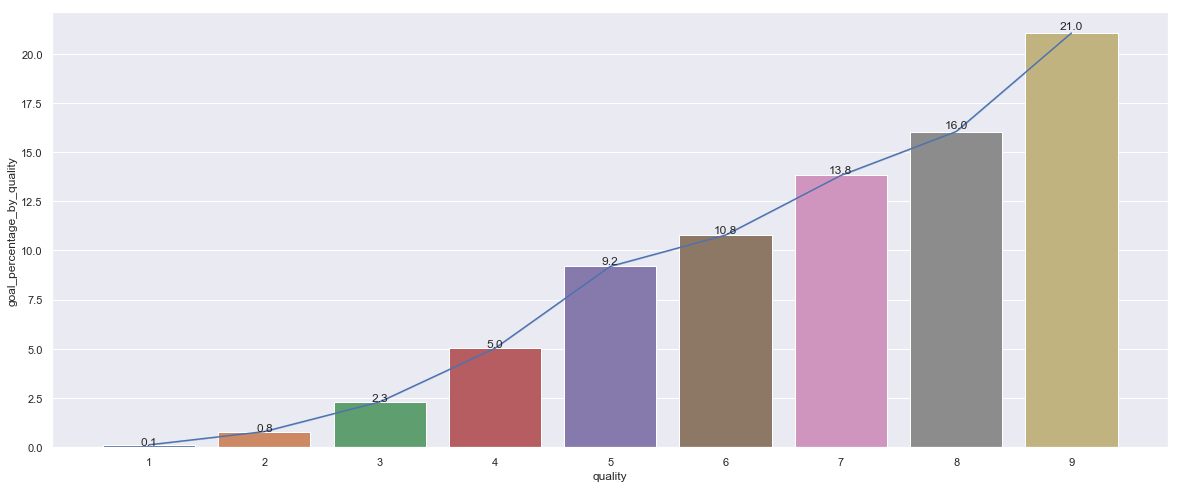

In [289]:
bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df2.drop_duplicates('quality'))
sns.lineplot(x=(df2['quality']-1), y='goal_percentage_by_quality', data = df2)
#Function from https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
show_values(bar_plot)

In [290]:
def get_goalie_SPAAsq(name):
    # Check each goalie's shots in different qualities to see performance
    df_vasy = df[df['goalieNameForShot']==name]
    df_vasy['goal_percentage_by_quality'] = (df_vasy.groupby('quality')['goal'].transform('sum') / df_vasy.groupby('quality')['goal'].transform('count')) * 100
    df_vasy_qualities = df_vasy.drop_duplicates('quality').sort_values('quality')

    bar_plot = sns.barplot(x='quality', y='goal_percentage_by_quality', data=df_vasy.drop_duplicates('quality'))
    sns.lineplot(x=(df_vasy['quality']-1), y='goal_percentage_by_quality', data = df_vasy)
    sns.lineplot(x=(df2['quality']-1), y='goal_percentage_by_quality', data = df2, color='red')
    show_values(bar_plot)
    
    average_goal_percentage_by_shot_quality.rename(columns={'goal_percentage_by_quality': 'average_goal_percentage'}, inplace=True)

    # Merge the DataFrames on the 'quality' column
    merged_df = df_vasy_qualities.merge(average_goal_percentage_by_shot_quality, on='quality', how='left')

    # Calculate the difference and create a new column 'SPAAsq'
    merged_df['SPAAsq'] = merged_df['average_goal_percentage'] - merged_df['goal_percentage_by_quality']
    return merged_df['SPAAsq']

<ipython-input-290-5b18202e4869>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vasy['goal_percentage_by_quality'] = (df_vasy.groupby('quality')['goal'].transform('sum') / df_vasy.groupby('quality')['goal'].transform('count')) * 100


0    0.123457
1   -0.380090
2    0.307757
3    1.014315
4   -0.388757
5    0.910710
6    1.894071
7    6.040549
8   -8.365253
Name: SPAAsq, dtype: float64

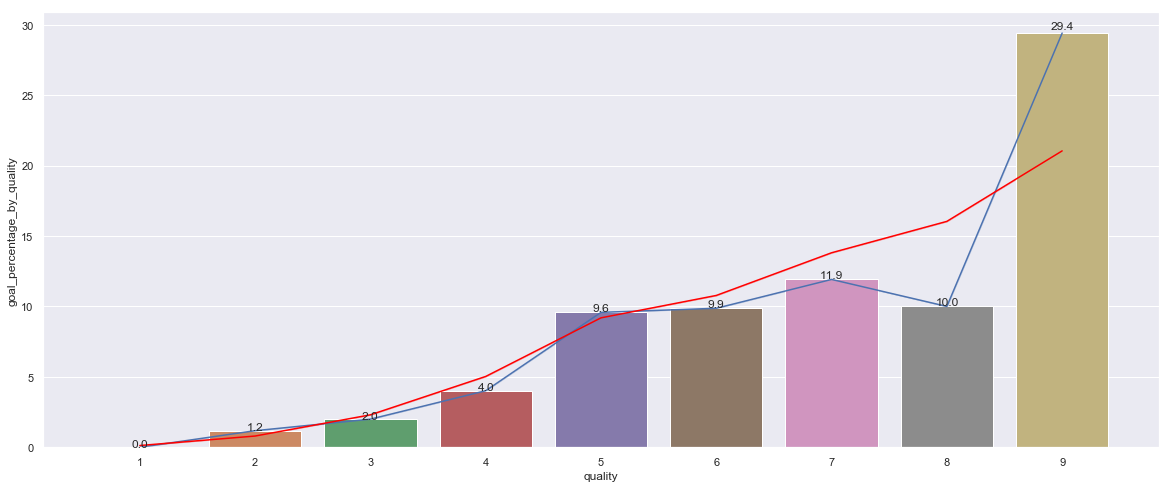

In [291]:
name = 'Andrei Vasilevskiy'
get_goalie_SPAAsq(name)

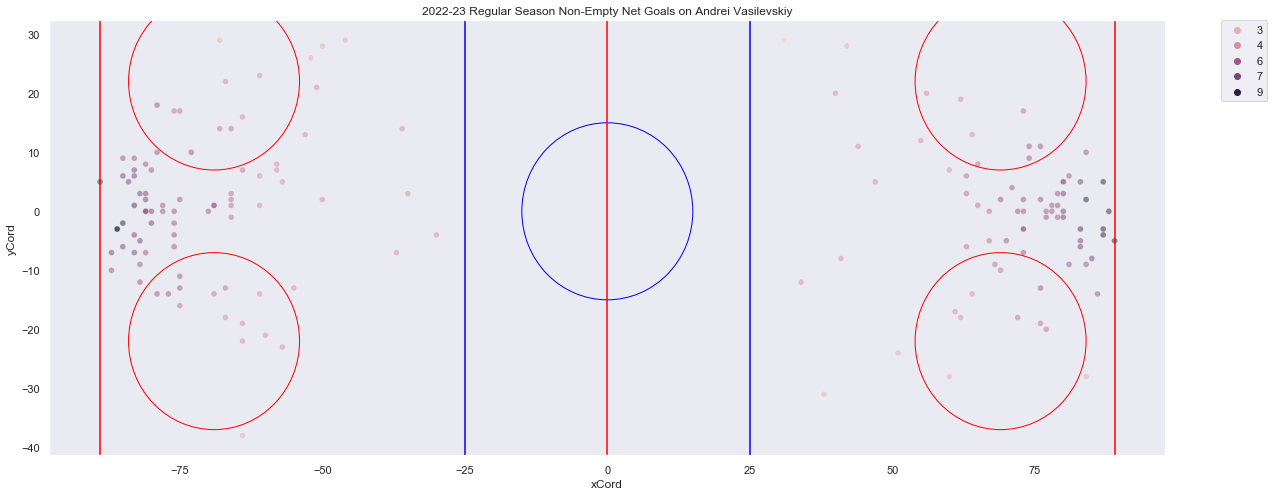

In [292]:
plot_rink(df_goals[df_goals['goalieNameForShot']==name], "2022-23 Regular Season Non-Empty Net Goals on "+name)

In [ ]:
# get percentiles for SPAAsq for each 'quality'